In [2]:
import sys
#Change path specificly to your directories
sys.path.insert(1, '/home/codahead/Fishial/FishialReaserch')

import time
import torch
import os
import cv2
import math 
import matplotlib.pyplot as plt
import torchvision.models as models
import numpy as np
from torch import nn
from torch.optim import Optimizer, SGD
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from sklearn.neighbors import KDTree
import pandas as pd
from module.classification_package.src.utils import read_json, save_json
from module.classification_package.interpreter_classifier import ClassifierFC
from module.classification_package.interpreter_embeding import EmbeddingClassifier
from module.classification_package.interpreter_embeding_data import EmbeddingClassifierData
from module.segmentation_package.interpreter_segm import SegmentationInference
from module.classification_package.src.dataset import FishialDataset
# from module.segmentation_package.src.utils import resize_image
from PIL import Image
import numpy as np
import random
import sklearn.metrics.pairwise
import scipy.spatial.distance
import copy
import json
import time
import requests
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from os import listdir
from module.classification_package.src.utils import read_json, save_json
from os.path import isfile, join
# TRESHOLD 40.6256
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [3]:
from module.segmentation_package.src.utils import get_mask

def get_mask_by_ann(data, ann, main_folder):
    polygon_tmp = []
    for pt in range(int(len(ann['segmentation'][0])/2)):
        polygon_tmp.append([int(ann['segmentation'][0][pt * 2]), int(ann['segmentation'][0][pt * 2 + 1])])
    img = get_image(data, main_folder, ann['image_id'])
    mask = get_mask(img, np.array(polygon_tmp))
    
    return mask, ann['image_id']

def get_image(data, folder_main, id):
    for img in data['images']:
        if img['id'] == id:
            return cv2.cvtColor(cv2.imread(os.path.join(folder_main, img['file_name'])), cv2.COLOR_BGR2RGB)
        

def hconcat_resize_min(im_list, interpolation=cv2.INTER_CUBIC):
    h_min = min(im.shape[0] for im in im_list)
    im_list_resize = [cv2.resize(im, (int(im.shape[1] * h_min / im.shape[0]), h_min), interpolation=interpolation)
                      for im in im_list]
    return cv2.hconcat(im_list_resize)

def get_image_by_ann_id(full_data, ann_id, main_folder = r'../../datasets/fishial_collection_V2.0/FULL'):
    for i in full_data['annotations']:
        if i['id'] == ann_id:
            image, image_id = get_mask_by_ann(full_data, i, main_folder)
            return image, image_id
        

def __remove_dupliceta(mylist):
        seen = set()
        newlist = []
        for item in mylist:
            t = tuple(item)
            if t[0] not in seen:
                newlist.append(item)
                seen.add(t[0])
        return newlist

In [4]:
data_base_train  = torch.load('../../output/train_results/resnet_18_98_finall_update/train_odm_embedding.pt').to('cpu')
data_base_labels = read_json('../../output/train_results/resnet_18_98_finall_update/train_odm_labels.json')
data_base_idx = read_json('../../output/train_results/resnet_18_98_finall_update/train_odm_idx.json')


In [5]:
full_data = read_json(r'../../../new_data_set/export_Verified_ALL_v2.json')

### Images whose distance is very low but has a different class

In [ ]:
for class_id_a, vec_per_class_a in enumerate(data_base):
    for a_idx, a in enumerate(vec_per_class_a):
        if a.sum() > 10000: continue
        src_img, src_img_id = get_image_by_ann_id(full_data, data_base_idx[str(class_id_a)][a_idx])
        print(f'CRNT: {class_id_a}/{a_idx}', end='\r')
        diff = torch.abs(data_base - a).sum(dim=2)
        val, indi = torch.sort(diff)
        
        for idx, i in enumerate(val):
            
            distancess = [round(asd, 4) for asd in i.to('cpu').numpy() if asd < 10000]
            mean_tmp_dist = np.mean(distancess)
            if class_id_a != idx:
                for disst_id, disst in enumerate(distancess):
                    if disst < 20:
                        ann_iddds = data_base_idx[str(idx)][indi[idx][int(indi[idx][disst_id])]]
                        
                        dst_img, dst_img_id = get_image_by_ann_id(full_data, ann_iddds)
                        print(f' distance: {round(disst, 4)} ')
                        print(f' ann id: {data_base_idx[str(class_id_a)][a_idx]} | image id: {src_img_id}')
                        print(f' ann id: {ann_iddds} | image id {dst_img_id}')
                        print(f' target/founded: {data_base_labels[str(class_id_a)]}/{data_base_labels[str(idx)]}')
                        plt.imshow(hconcat_resize_min([src_img, dst_img]))
                        plt.show()

In [ ]:
data_checker = { data_base_labels[str(label_id)]: [] for label_id in range(len(data_base)) }
for class_id_a, vec_per_class_a in enumerate(data_base):
    for a_idx, a in enumerate(vec_per_class_a):
        if a.sum() > 10000: continue
        print(f'crnt: {a_idx}/{class_id_a}', end='\r')
        data_checker[data_base_labels[str(class_id_a)]].append([])
        for b_idx, b in enumerate(vec_per_class_a):
            if b.sum() > 10000: continue
            if a_idx == b_idx: continue
            emb_dist = (a - b).abs().sum()
            data_checker[data_base_labels[str(class_id_a)]][a_idx].append(float(emb_dist))
#             print(class_id_a, a_idx,len(data_checker[data_base_labels[str(class_id_a)]][a_idx]))

### Images whose average distance is 50% or more different from the class average,

In [ ]:
num = 0
for idx, i in enumerate(data_checker):
    mean_per_image = [np.mean(z) for z in data_checker[i]]
    mean_per_class = np.mean(mean_per_image)
    for k_idx, k in enumerate(mean_per_image):
        if k/mean_per_class > 1.5:
            src_img, src_img_id = get_image_by_ann_id(full_data, data_base_idx[str(idx)][k_idx])
            num += 1
            print(f"num: {num} div: {round(float(k/mean_per_class), 2)} Class: {i} ann id: {data_base_idx[str(idx)][k_idx]} img id: {src_img_id}")
            plt.imshow(src_img)
            plt.show()

In [10]:
top_k = 20

data_truth = {}
for class_id_a, vec_per_class_a in enumerate(data_base_train):
    print(f"{class_id_a}: {len([0 for vec in vec_per_class_a if vec.sum() < 10000])}: {data_base_labels[str(class_id_a)]}")
    for a_idx, a in enumerate(vec_per_class_a):
        if a.sum() > 10000: continue
        print(f'CRNT: {class_id_a}/{a_idx}', end='\r')
        diff = (data_base_train - a).pow(2).sum(dim=2).sqrt()
        val, indi = torch.sort(diff)
        class_lib = []
        for idx, i in enumerate(val):
            #return only top N(12) elements from each class
            for dist_idx, dist in enumerate(i[:25]):
                if dist == 0.0: continue 
                if dist < 4:
                    class_lib.append([idx, dist,data_base_idx[str(idx)][indi[idx][dist_idx]] ])
        topest = sorted(class_lib, key=lambda x: x[1], reverse=False)
        my_dict = [[i[0], [iii[0] for iii in topest[:top_k]].count(i[0]), i[1], i[2]] for i in topest[:top_k]]
        my_dict = sorted(my_dict, key=lambda x: x[1], reverse=True)
        my_dict = [[match[0], match[2], match[3]] for match in my_dict]
        my_dict = my_dict[:1] + sorted(my_dict[1:], key=lambda x: x[1], reverse=True)
        
        data_truth.update({
            data_base_idx[str(class_id_a)][a_idx]: {
                'label': data_base_labels[str(class_id_a)],
                'pred': []
            }
        })
        
        
        for asd in my_dict: 
            if asd[0] == class_id_a: continue
            data_truth[data_base_idx[str(class_id_a)][a_idx]]['pred'].append({
                'label': data_base_labels[str(asd[0])],
                'dst': asd[2]
            })


0: 281: Lepomis macrochirus
1: 237: Pomatomus saltatrix
2: 237: Pogonias cromis
3: 188: Esox lucius
4: 168: Amia calva
5: 158: Micropogonias undulatus
6: 153: Micropterus salmoides
7: 151: Lachnolaimus maximus
8: 148: Scomberomorus cavalla
9: 144: Coryphaena hippurus
10: 142: Sciaenops ocellatus
11: 141: Cyprinus carpio
12: 140: Caranx hippos
13: 138: Lobotes surinamensis
14: 131: Lutjanus analis
15: 130: Scomberomorus maculatus
16: 130: Oncorhynchus clarkii
17: 129: Lepomis gulosus
18: 127: Perca fluviatilis
19: 127: Pomoxis nigromaculatus
20: 125: Lutjanus argentimaculatus
21: 124: Salvelinus fontinalis
22: 124: Oncorhynchus tshawytscha
23: 124: Ambloplites rupestris
24: 123: Cynoscion nebulosus
25: 122: Pomoxis annularis
26: 121: Morone saxatilis
27: 121: Mycteroperca bonaci
28: 121: Seriola dumerili
29: 121: Morone chrysops
30: 121: Cichla ocellaris
31: 120: Esox niger
32: 119: Lepomis cyanellus
33: 118: Esox masquinongy
34: 117: Sphyraena barracuda
35: 117: Ictalurus punctatus
36:

Nr  | annotation_id:                     | image_id: | label in COCO: | supposed by AI: |
 1 | bd9240e1-ea39-5079-a66c-e2a7bb985a46 | 58792 | Lepomis macrochirus | Lepomis microlophus


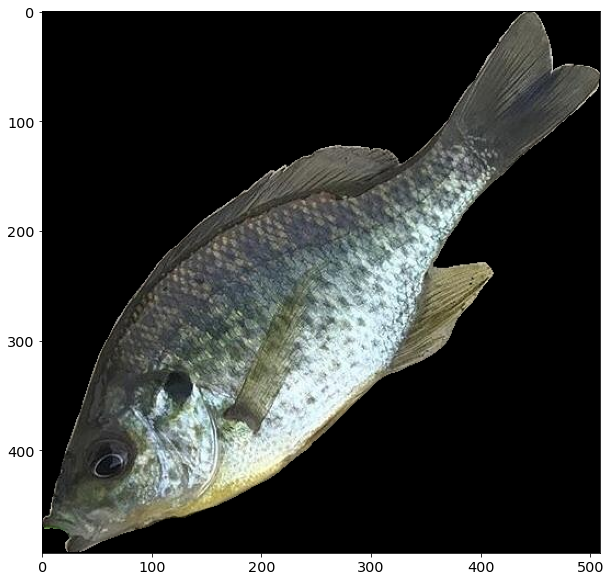

 2 | 54cef2a5-ba04-5621-81fd-da50c63384ab | 66135 | Esox lucius | Esox niger


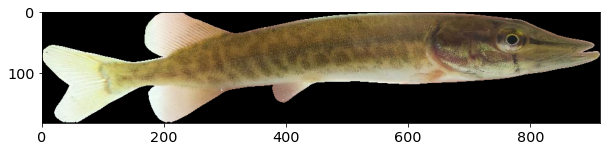

 3 | 6e163adc-d892-5128-8711-4c547050c4a6 | 14688 | Micropterus salmoides | Micropterus punctulatus


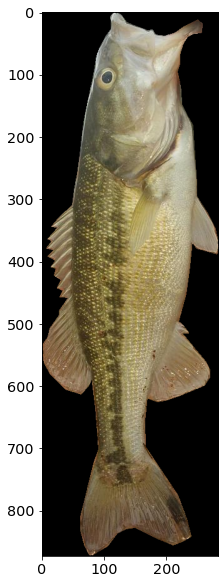

 4 | 0a074731-1e50-5bf9-a312-5022e85cb82a | 193269 | Micropterus salmoides | Micropterus punctulatus


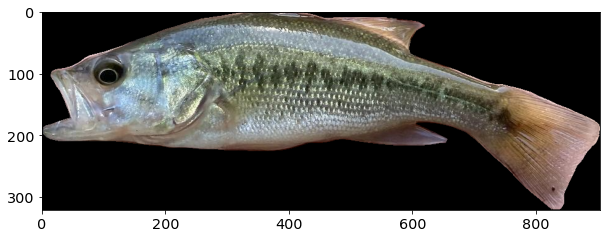

 5 | 3442e7a8-cf9d-5a5b-a6b1-a2f6a7907864 | 193306 | Micropterus salmoides | Micropterus punctulatus


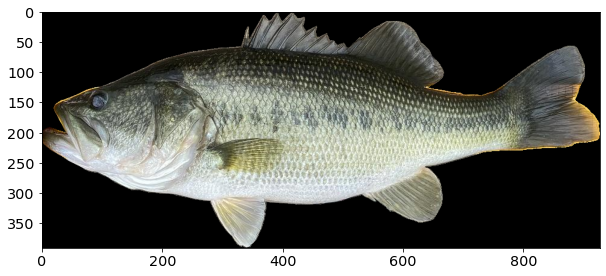

 6 | 18ae5075-2264-59bc-91fa-a28da9e0148c | 193477 | Micropterus salmoides | Micropterus punctulatus


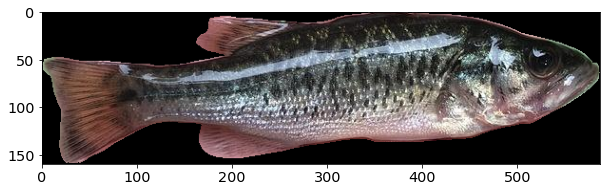

 7 | 9d138ccb-9d33-5a81-adcb-e97c34420c0f | 70615 | Pomoxis nigromaculatus | Pomoxis annularis


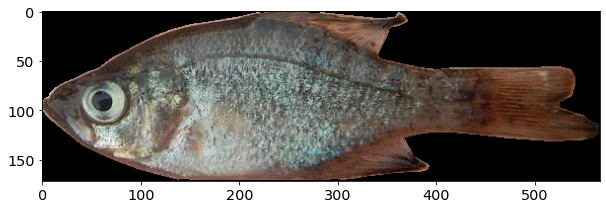

 8 | a22e530a-d4e2-594e-a5c7-fb96ce3fc72b | 70669 | Pomoxis nigromaculatus | Pomoxis annularis


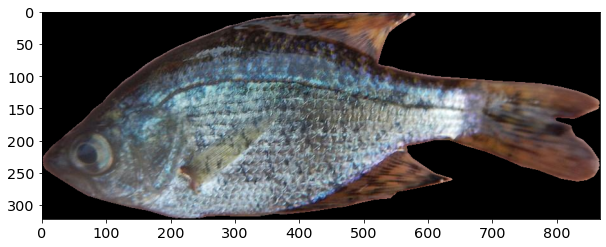

 9 | d766cf17-8696-5080-b9fd-f682048dbfc4 | 70629 | Pomoxis annularis | Pomoxis nigromaculatus


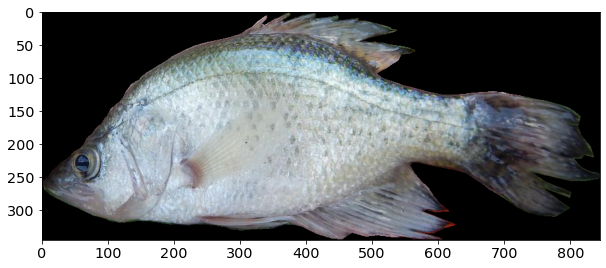

 10 | 939dce8e-47dd-5390-a511-6f60472959e5 | 70650 | Pomoxis annularis | Pomoxis nigromaculatus


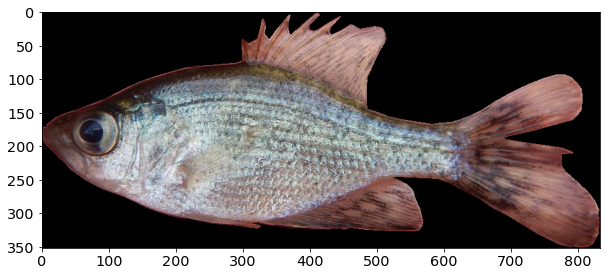

 11 | 70107e96-cef2-557f-b216-7ae411d1da4c | 70721 | Pomoxis annularis | Pomoxis nigromaculatus


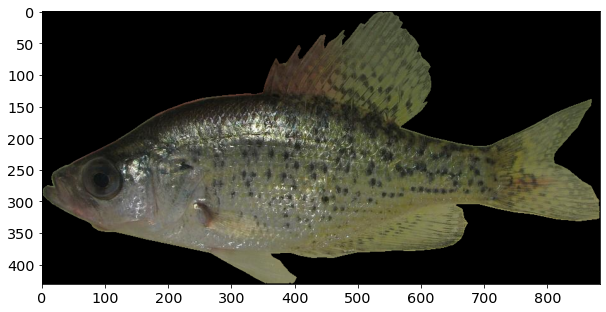

 12 | 7e269860-31ac-5c6b-ba60-907069549045 | 71423 | Pomoxis annularis | Pomoxis nigromaculatus


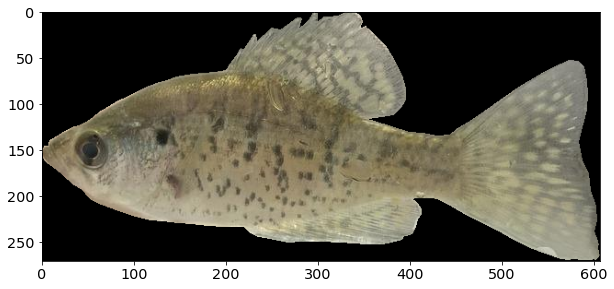

 13 | 7ca19cdd-67d7-59d0-80af-2466f0b596ea | 6339 | Esox niger | Esox lucius


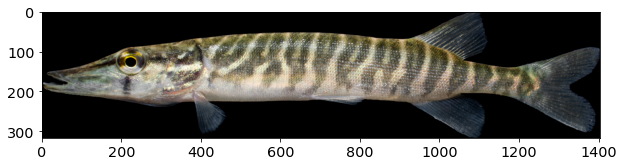

 14 | 458fbf7c-3ff6-5d81-bf95-1926fd2df305 | 81332 | Esox niger | Esox lucius


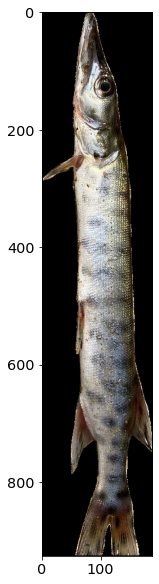

 15 | e2665566-1ff2-5ab6-b265-e84cb057e860 | 56084 | Ictalurus punctatus | Ictalurus furcatus


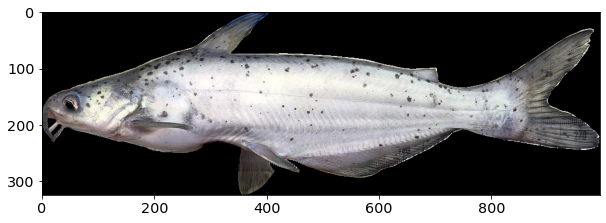

 16 | 69e44583-e6e1-5280-b193-edb0d4272b48 | 94922 | Paralichthys dentatus | Paralichthys lethostigma


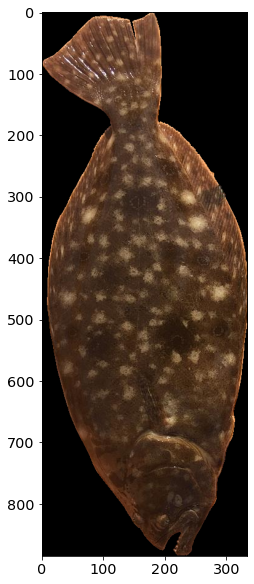

 17 | f09b1d6d-5a02-5f00-a1bb-3e3e0ebbab2a | 94929 | Paralichthys dentatus | Paralichthys lethostigma


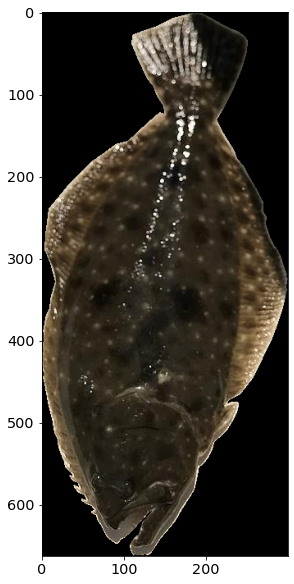

 18 | b1036a0a-af00-5f34-9882-b3a0fa8688d7 | 94948 | Paralichthys dentatus | Paralichthys lethostigma


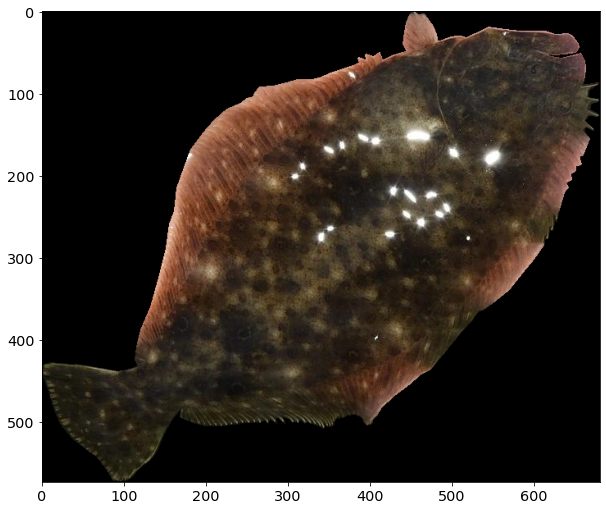

 19 | 9598fb62-136f-5fdf-932d-cc929157df47 | 94995 | Paralichthys dentatus | Paralichthys lethostigma


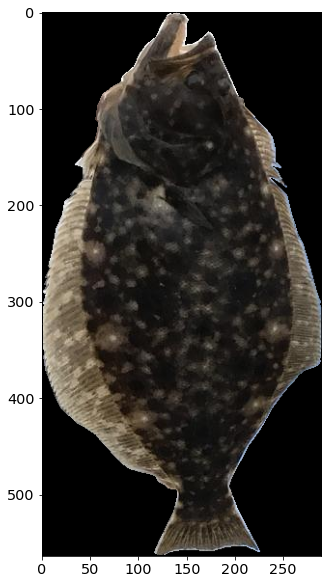

 20 | 4b138c72-a887-555b-95c5-8c57bee6b2b8 | 94998 | Paralichthys dentatus | Paralichthys lethostigma


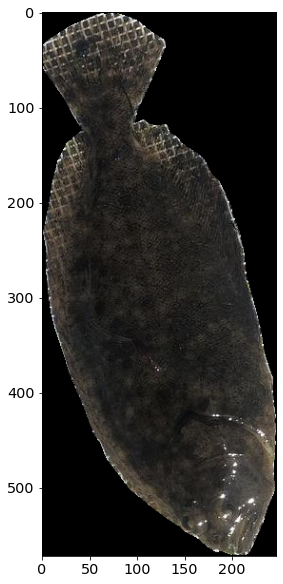

 21 | a3ee208f-c7e1-57ad-bf28-1b14b7283cd3 | 95004 | Paralichthys dentatus | Paralichthys lethostigma


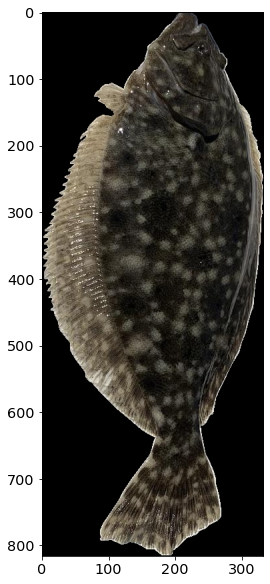

 22 | 5b80c6a8-3541-5534-b9ea-d54184fbacee | 55623 | Ameiurus nebulosus | Ameiurus melas


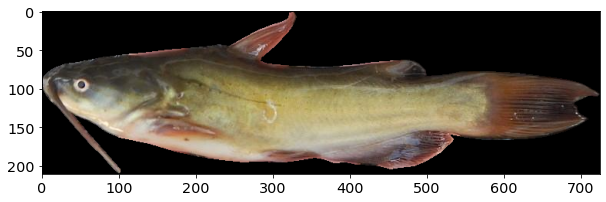

 23 | fca92b9b-3db0-5557-9198-c95e1f24e0f2 | 76840 | Micropterus punctulatus | Micropterus salmoides


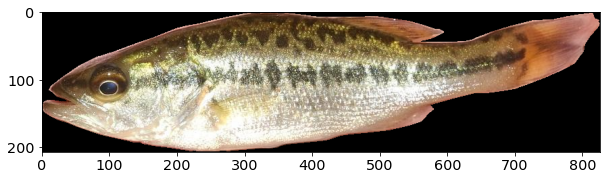

 24 | 1a673435-58fd-5641-8ce0-a7665b7bf21b | 126740 | Paralichthys lethostigma | Paralichthys dentatus


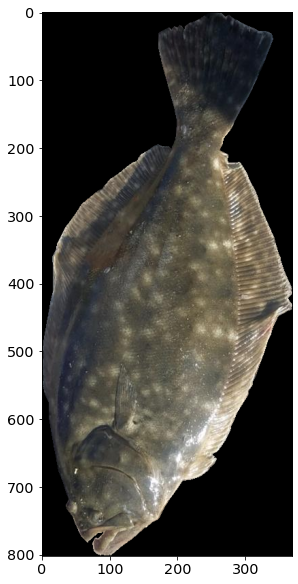

 25 | 9c8ac3c1-6d69-5cad-8bbf-776ca272f718 | 126754 | Paralichthys lethostigma | Paralichthys dentatus


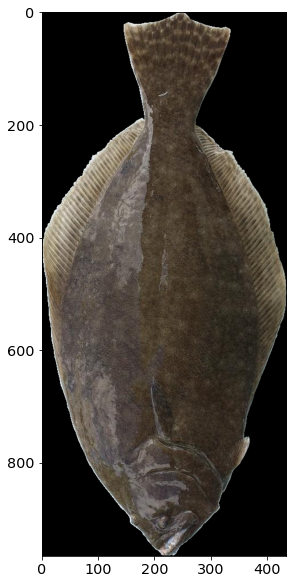

 26 | a05dc83f-c362-5e58-9b80-5c393c16baaa | 126878 | Paralichthys lethostigma | Paralichthys dentatus


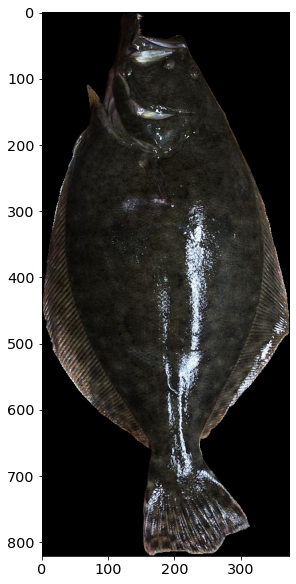

 27 | f90dd996-2c0c-5edc-b522-a62080f78711 | 126892 | Paralichthys lethostigma | Paralichthys dentatus


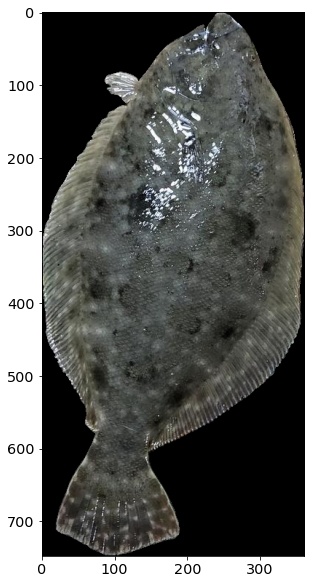

In [28]:
cnt = 0
print("Nr  | annotation_id:                     | image_id: | label in COCO: | supposed by AI: |")
for idx, i in enumerate(data_truth):
#     print(len(data_truth[i]['ann_id']))
    
    if len(data_truth[i]['pred'])> 3:
        cnt+= 1
        
        img = get_image_by_ann_id(full_data, i)
        print(" {} | {} | {} | {} | {}".format(
            cnt, 
            i,
            img[1], 
            data_truth[i]['label'], 
            list(set([ann['label'] for ann in data_truth[i]['pred']]))[0]
        ))
        
        plt.imshow(img[0])
        plt.show()
#         for ann in data_truth[i]['pred']:
#             print("name dst: ", ann['label'], ann['dst'])
#             img = get_image_by_ann_id(full_data, ann['dst'])
#             plt.imshow(img[0])
#             plt.show()
#         print(20 * "=")
#     print(data_truth[i])
#     print("--")
#     for zxc in range(len(data_truth[i]['pred'])):
#         if len(data_truth[i]['pred'][zxc])> 0:
            
#             print("src: {} ann: {}".format(data_base_labels[str(idx)], data_truth[i]['ann_id'][zxc]))
#             print(data_truth[i]['pred'][zxc])
#             img = get_image_by_ann_id(full_data, data_truth[i]['ann_id'][zxc])
#             plt.imshow(img[0])
#             plt.show()
#             for xcv in data_truth[i]['pred'][zxc]:
#                 print("dst id: {}  ann id {}".format(data_base_labels[str(xcv[0])], xcv[1]))
#                 img = get_image_by_ann_id(full_data, xcv[1])
#                 plt.imshow(img[0])
#                 plt.show()
            
# #     ASDAS = [z for z in data_truth[i][0]]
# #     print("Main: ",data_base_labels[str(i)], len([0 for vec in data_base_test[i] if vec.sum() < 10000]), len(ASDAS))
# #     unique = set(ASDAS)
# #     for z in unique:
# #         print("    :  {} | {}".format(data_base_labels[str(z)], len([0 for vec in data_base_train[z] if vec.sum() < 10000])))